<a href="https://colab.research.google.com/github/AlirezaPNouri/Papers/blob/main/Experimental_result_four_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final_experimental results for the paper, including four different metrics such as Dispersion, TempoCover, StoryStretch, and Story Evaluaion Coefficient(SEC)

In [41]:
# needed packages
import requests
import numpy as np
import pandas as pd
import string
import pickle
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import median, array, exp
from sklearn.cluster import KMeans
import copy
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from nltk.tokenize import word_tokenize

In [2]:
#constant variables

In [3]:
#load objects

final_results_proposed = pickle.load(open('drive/MyDrive/temp/data_r/final_results_proposed.p', 'rb'))
final_results_bert = pickle.load(open('drive/MyDrive/temp/data_r/final_results_bert.p', 'rb'))
final_results_ji = pickle.load(open('drive/MyDrive/temp/data_r/final_results_ji.p', 'rb'))
final_results_doc2vec = pickle.load(open('drive/MyDrive/temp/data_r/final_results_doc2vec.p', 'rb'))
total_doc_embedding_cls = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/total_docs_clusters_wo_stopwords.p', 'rb'))
list_of_timestamps = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/list_of_timestamps.p', 'rb'))

In [93]:
# print(final_results_proposed.keys())
# print(len(final_results_proposed[0.95]))
# print(final_results_proposed[0.95])
# print(len(final_results_doc2vec[0.95]))
# print(final_results_doc2vec[0.95])

### StortStretch  = 1 - sqrt(sum(l_i - L_bar))/ (|S| L_bar)    

In [5]:

def story_stretch(story_list, max_omega):
  stories = story_list[max_omega]
  stories_length = list()
  for story in stories:
    stories_length.append(len(story))
  ave = np.average(stories_length)
  return 1- np.sqrt(np.average([pow(l_i - ave,2) for l_i in stories_length])) / len(stories)

In [94]:
thre = 0.85
print('StoryStretch Metric')
print(story_stretch(final_results_proposed, thre))
print(story_stretch(final_results_bert, thre))
print(story_stretch(final_results_ji, thre))
print(story_stretch(final_results_doc2vec, thre))

StoryStretch Metric
0.9716492038600091
0.8767638341972683
0.8338568028771833
0.9582311354000781


In [43]:
omega_list = final_results_proposed.keys()
story_stretch_proposed = [story_stretch(final_results_proposed, i) for i in omega_list]
story_stretch_bert = [story_stretch(final_results_bert, i) for i in omega_list]
story_stretch_ji = [story_stretch(final_results_ji, i) for i in omega_list]
story_stretch_doc2vec = [story_stretch(final_results_doc2vec, i) for i in omega_list]

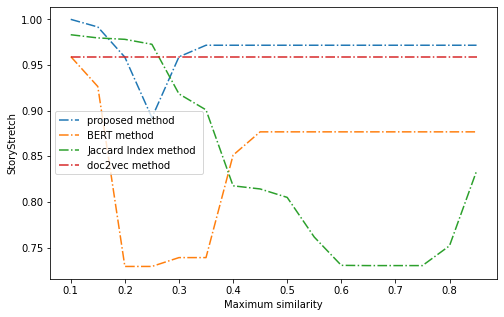

In [8]:


x = list(omega_list)[0:-2]
plt.figure(figsize=(8,5))

y = story_stretch_proposed[0:-2]
plt.plot(x, y, label = "proposed method ", linestyle="-." )

y = story_stretch_bert[0:-2]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = story_stretch_ji[0:-2]
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = story_stretch_doc2vec[0:-2]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

plt.xlabel('Maximum similarity')
plt.ylabel('StoryStretch')

plt.legend()
plt.show()

### Temporal Coverage *Metric*

In [95]:
# print(len(list_of_timestamps))
# print(list_of_timestamps[0])

In [10]:
def tempo_cover(story_list, timestamp_list, omega):
  stories_list = story_list[omega]
  res = list()
  for story in stories_list:
    ts_counter = set()
    for t_s in range(len(timestamp_list)):
      for doc in story:
        if doc in timestamp_list[t_s]:
          ts_counter.add(t_s)
    res.append(len(ts_counter)/len(story))
  return np.average(res)

        



In [97]:
thre = 0.90
print('TempoCover Metric')
print(tempo_cover(final_results_proposed, list_of_timestamps, thre))
print(tempo_cover(final_results_bert, list_of_timestamps, thre))
print(tempo_cover(final_results_ji, list_of_timestamps, thre))
print(tempo_cover(final_results_doc2vec, list_of_timestamps, thre))


TempoCover Metric
0.7617602791773651
0.2820673614582169
0.3072190351712336
0.3751152072636012


In [12]:
omega_list = final_results_proposed.keys()
tempo_cover_proposed = [tempo_cover(final_results_proposed, list_of_timestamps, i) for i in omega_list]
tempo_cover_bert = [tempo_cover(final_results_bert, list_of_timestamps, i) for i in omega_list]
tempo_cover_ji = [tempo_cover(final_results_ji, list_of_timestamps, i) for i in omega_list]
tempo_cover_doc2vec = [tempo_cover(final_results_doc2vec, list_of_timestamps, i) for i in omega_list]

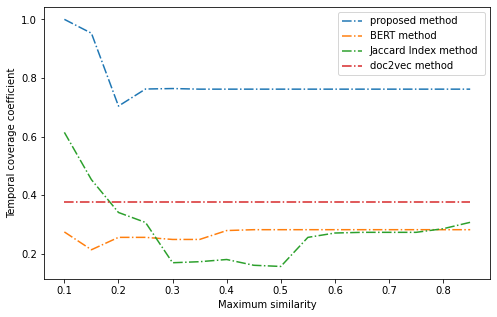

In [13]:
x = list(omega_list)[0:-2]
plt.figure(figsize=(8,5))

y = tempo_cover_proposed[0:-2]
plt.plot(x, y, label = "proposed method ", linestyle="-." )

y = tempo_cover_bert[0:-2]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = tempo_cover_ji[0:-2]
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = tempo_cover_doc2vec[0:-2]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

plt.xlabel('Maximum similarity')
plt.ylabel('Temporal coverage coefficient')

plt.legend()
plt.show()

### Dispersion coefficient

In [18]:
#generate embedding for evaluation metrics

Embed_dict = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/Embed_dict.p', 'rb'))

total_doc_embedding = dict()
for t_ in Embed_dict.keys():
  for doc in Embed_dict[t_].keys():
    total_doc_embedding[doc] = Embed_dict[t_][doc]


total_doc_embedding_cls = dict()
for doc in total_doc_embedding.keys():
  total_doc_embedding_cls[doc] = total_doc_embedding[doc]['cls']


full_story_NYT_proposed_embedding = dict()
for omega in final_results_proposed.keys():
  temp_story_list = list()
  for story in final_results_proposed[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_proposed_embedding[omega] = temp_story_list


full_story_NYT_bert_embedding = dict()
for omega in final_results_bert.keys():
  temp_story_list = list()
  for story in final_results_bert[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_bert_embedding[omega] = temp_story_list


full_story_NYT_ji_embedding = dict()
for omega in final_results_ji.keys():
  temp_story_list = list()
  for story in final_results_ji[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_ji_embedding[omega] = temp_story_list


full_story_NYT_doc2vec_embedding = dict()
for omega in final_results_doc2vec.keys():
  temp_story_list = list()
  for story in final_results_doc2vec[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_doc2vec_embedding[omega] = temp_story_list

In [63]:
def disp(d_i, d_j, n, teta, i, j):
  a = np.array(d_i)
  b = np.array(d_j)
  dist = cosine_similarity([a],[b])[0][0]
  if dist < teta:
    return 1/(n+i-j)
  else:
    return 0


# def disp(d_i, d_j, n, teta, i, j):
#   a = np.array(d_i)
#   b = np.array(d_j)
#   dist = np.sqrt(np.sum(np.square(a-b))) / len(d_i)
#   if dist < teta:
#     return 1/(n+i-j)
#   else:
#     return 0


In [31]:
def final_disp(story_, teta):
  res = list()
  len_story = len(story_)
  for i in range(len_story-3):
    for j in range(i+2, len_story-1):
      res.append(disp(story_[i], story_[j], len_story, teta, i, j))
  
  return 1.0 - (sum(res)/(len_story-2 + 0.01))

In [33]:
# sample = full_story_NYT_proposed_embedding[0.95][0]
# res = list()
# len_story = len(sample)
# for i in range(len_story-3):
#     for j in range(i+2, len_story-1):
#       res.append(disp(sample[i], sample[j], len_story, 0.025, i, j))
# final_res =  1.0 - (sum(res)/(len_story-2 + 0.01))

In [67]:
# disp_porposed = list()
# disp_bert = list()
# disp_ji = list()
# disp_doc2vec = list()
# # omega_list = [0.9]
# for om in tqdm(omega_list): 
#   g_value = [final_disp(x, 0.025) for x in full_story_NYT_proposed_embedding[om]]
#   disp_porposed.append(sum(g_value)/ len(g_value))
#   f_value = [final_disp(x, 0.025) for x in full_story_NYT_bert_embedding[om]]
#   disp_bert.append(sum(f_value)/ len(f_value))
#   z_value = [final_disp(x, 0.025) for x in full_story_NYT_ji_embedding[om]]
#   disp_ji.append(sum(z_value)/  len(z_value))
#   a_value = [final_disp(x, 0.025) for x in full_story_NYT_doc2vec_embedding[om]]
#   disp_doc2vec.append(sum(a_value)/len(a_value))



disp_porposed = list()
disp_bert = list()
disp_ji = list()
disp_doc2vec = list()
teta_list = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for te_ta in tqdm(teta_list): 
  g_value = [final_disp(x, te_ta) for x in full_story_NYT_proposed_embedding[0.85]]
  disp_porposed.append(sum(g_value)/ len(g_value))
  f_value = [final_disp(x, te_ta) for x in full_story_NYT_bert_embedding[0.85]]
  disp_bert.append(sum(f_value)/ len(f_value))
  z_value = [final_disp(x, te_ta) for x in full_story_NYT_ji_embedding[0.85]]
  disp_ji.append(sum(z_value)/  len(z_value))
  a_value = [final_disp(x, te_ta) for x in full_story_NYT_doc2vec_embedding[0.85]]
  disp_doc2vec.append(sum(a_value)/len(a_value))

100%|██████████| 6/6 [15:20<00:00, 153.45s/it]


In [103]:
i = -1
print('Dispersion Coefficient metric')

print(disp_porposed[3])
print(disp_bert[3])
print(disp_ji[3])
print(disp_doc2vec[3])


Dispersion Coefficient metric
0.9780213397607616
0.9494829246890243
0.8967454500361282
0.7363513407286173


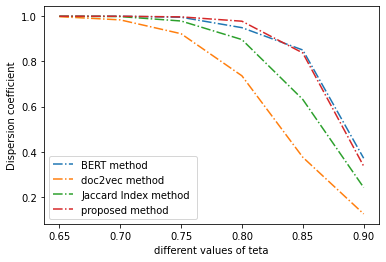

In [92]:

y = disp_bert
x = teta_list
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = disp_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = disp_ji
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = disp_porposed
plt.plot(x, y, label = "proposed method ", linestyle="-." )
plt.xlabel('different values of teta')
plt.ylabel('Dispersion coefficient')
plt.legend()
plt.show()

### Story Evolution Coefficient (SEC)

In [74]:
def story_evaluation_avg (stories_embedding, t_max):
  n_stories = len(stories_embedding)
  res = list()
  for story in stories_embedding:
    temp_res = list()
    for i in range(len(story)-1):
      temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
      temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
    res.append(np.average(temp_res))
  return np.average(res)


def story_evaluation_vec (stories_embedding, t_max):
  n_stories = len(stories_embedding)
  res = list()
  for story in stories_embedding:
    temp_res = list()
    for i in range(len(story)-1):
      temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
      temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
    res.append(np.average(temp_res))
  return res


In [105]:
print('Story Evolution Coefficient (SEC)')
s_sa = full_story_NYT_proposed_embedding[0.9]
print(story_evaluation_avg(s_sa, 0.9))
s_sa = full_story_NYT_doc2vec_embedding[0.9]
print(story_evaluation_avg(s_sa, 0.9))
s_sa = full_story_NYT_ji_embedding[0.9]
print(story_evaluation_avg(s_sa, 0.9))
s_sa = full_story_NYT_bert_embedding[0.9]
print(story_evaluation_avg(s_sa, 0.9))

Story Evolution Coefficient (SEC)
0.9809849320704602
0.8606826378498613
0.9415692651125961
0.9262356019169947


In [78]:
NYT_proposed = (story_evaluation_vec(full_story_NYT_proposed_embedding[0.9], 0.9))
NYT_doc2vec = (story_evaluation_vec(full_story_NYT_doc2vec_embedding[0.9], 0.9))
NYT_ji = (story_evaluation_vec(full_story_NYT_ji_embedding[0.9], 0.9))
NYT_bert = (story_evaluation_vec(full_story_NYT_bert_embedding[0.9], 0.9))


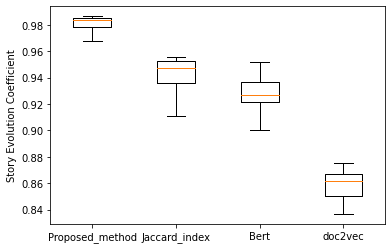

In [106]:
data = [NYT_proposed, NYT_ji, NYT_bert, NYT_doc2vec]
 
fig = plt.figure(figsize =(6, 4))
 
plt.boxplot(data,showfliers=False,labels=['Proposed_method','Jaccard_index','Bert','doc2vec'])
plt.ylabel("Story Evolution Coefficient")

plt.show()